# Generate and Store Dataset

In [29]:
from BasicDataProcessing.generate_train_labels import list_audios
from BasicDataProcessing.generate_spectrograms import *
import numpy as np

In [4]:
audio_list = list_audios("../voxceleb1/vox1_dev_partaa/")

In [5]:
%cd ../voxceleb1/vox1_dev_partaa/

/Users/zeba/Desktop/speakerVerification/voxceleb1/vox1_dev_partaa


Creates the spectrograms for the dataset and store in a dictionary

In [6]:
spectrograms = mel_spectrograms(audio_list, 3000, 16000, 64, 20, 10)

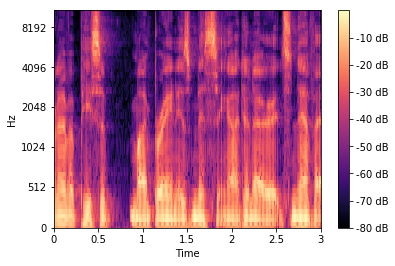

In [7]:
stride_size = int(0.001 * 16000 * 10)
display_spectrogram(spectrograms["id10022/ZXYlWu1JfKU/00024.wav"], 16000, stride_size)

In [8]:
len(spectrograms)

48840

Dumps the spectrograms using Pickle, for faster setup.

In [14]:
import pickle
import time
start_time = time.time()

with open("melSpecSr3seg16KHz64mels20wd10stride.txt", "wb") as myFile:
    pickle.dump(spectrograms, myFile)
        
print("--- %s seconds ---" % (time.time() - start_time))

--- 5.596835136413574 seconds ---


How to load the spectrograms using Pickle (the path might change)

In [15]:
with open("melSpecSr3seg16KHz64mels20wd10stride.txt", "rb") as myFile:
    spectrograms = pickle.load(myFile)

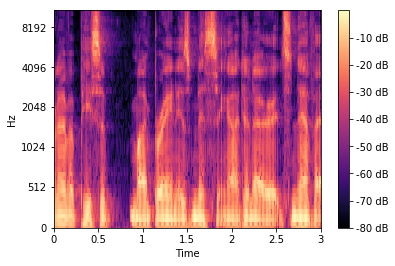

In [16]:
stride_size = int(0.001 * 16000 * 10)
display_spectrogram(spectrograms["id10022/ZXYlWu1JfKU/00024.wav"], 16000, stride_size)

In [18]:
spectrograms["id10022/ZXYlWu1JfKU/00024.wav"].shape

(64, 301)

In [21]:
%cd ../../SpeakerVerificationML/

/Users/zeba/Desktop/speakerVerification/SpeakerVerificationML


In [39]:
train_list_audios_x = []
train_list_y = []
with open("../voxceleb1/veri_train.txt") as train_labels_file:
    for line in train_labels_file:
        splitted = line.split()
        train_list_y.append(splitted[0])
        train_list_audios_x.append([splitted[1],splitted[2]])

train_y = np.zeros((len(train_list_y), 1))

for i in range(len(train_list_y)):
    train_y[i] = train_list_y[i]
    
print(train_y.shape)
print(len(train_list_audios_x))

(311260, 1)
311260


In [92]:
train_list_audios_x[311259]

['id10216/UoDyUyAe6O4/00005.wav', 'id10216/AEI-0E-jiF4/00007.wav']

In [93]:
#Generates mini batches using the spectrograms as channels. A pair = 2 channels
def generate_mini_batch(size, index, spectrograms, spec_shape, train_y, train_list_audios_x):
    min_index = index*size
    max_index = len(train_list_audios_x) if (len(train_list_audios_x) <= (index+1)*size) else (index+1)*size
    
    mini_batch_x = np.zeros((max_index - min_index, 2, spec_shape[0], spec_shape[1]))
    mini_batch_y = train_y[min_index : max_index]
    for i in range(min_index, max_index):
        mini_batch_x[i - min_index][0] = spectrograms[train_list_audios_x[i][0]]
        mini_batch_x[i - min_index][1] = spectrograms[train_list_audios_x[i][1]]
        
    return mini_batch_x, mini_batch_y
    

In [95]:
generate_mini_batch(16, 19452, spectrograms, (64, 301), train_y, train_list_audios_x)

(array([[[[-44.85087585, -32.35400391, -29.88194466, ..., -37.34885788,
           -36.93446732, -11.45058441],
          [-38.27891541, -36.18994141, -31.11603737, ..., -32.07846069,
           -17.83762169, -10.04480362],
          [-41.30822754, -38.46740723, -35.9896698 , ..., -29.40718269,
           -12.47841835, -15.40632439],
          ...,
          [-78.40619659, -74.11980438, -71.3182373 , ..., -40.20526123,
           -39.71114349, -43.43927765],
          [-74.77893829, -75.38790131, -72.09797668, ..., -44.49540329,
           -41.53761292, -45.01148987],
          [-76.86573792, -74.52418518, -75.27624512, ..., -44.96780396,
           -43.89508057, -46.45248032]],
 
         [[-23.04561234, -49.52103424, -45.16053009, ..., -35.60456848,
           -45.74680328, -43.25532532],
          [-23.28510475, -43.63887024, -50.95021057, ..., -26.02960396,
           -39.07238007, -49.72969818],
          [-21.21988487, -38.32309723, -36.53411865, ..., -28.21964455,
           -34

Sanity check

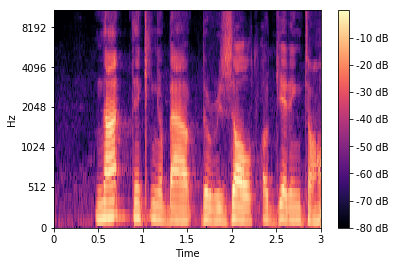

In [47]:
stride_size = int(0.001 * 16000 * 10)
display_spectrogram(spectrograms['id10545/AXUSWMHVUfM/00023.wav'], 16000, stride_size)

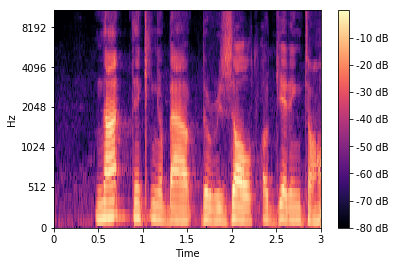

In [48]:
mini_batch_x, mini_batch_y = generate_mini_batch(1, 0, spectrograms, (64, 301), train_y, train_list_audios_x)
display_spectrogram(mini_batch_x[0][0], 16000, stride_size)

In [53]:
type(spectrograms['id10545/AXUSWMHVUfM/00023.wav'][0][0])

numpy.float32

# Model Protoypes

In [77]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import Model, Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras import backend
from tensorflow.keras.optimizers import SGD

backend.set_floatx('float32')

In [67]:
'''
class ConvNet(Sequential):
  def __init__(self, input_shape, num_classes):
    super().__init__()
    self.add(Conv2D(48, kernel_size=(6,6), strides= 2,
                    padding= 'valid', activation= 'relu',
                    input_shape= input_shape, kernel_initializer= 'he_normal'))
    self.add(MaxPooling2D(pool_size=(4,4), strides= (2,2),
                          padding= 'valid', data_format= None))
    
    #self.add(Flatten())
    self.add(Dense(48, activation='relu'))
    self.add(Dense(num_classes, activation='softmax'))

    self.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
'''

In [82]:
# Get the model.
inputs = Input(shape=(2, 64, 301), name='spectrograms')
x = Flatten()(inputs)
x = Dense(64, activation='relu', name='dense_1')(x)
x = Dense(64, activation='relu', name='dense_2')(x)
outputs = Dense(2, name='predictions')(x)
model = Model(inputs=inputs, outputs=outputs)

# Instantiate an optimizer.
optimizer = SGD(learning_rate=1e-3)
# Instantiate a loss function.
loss_fn = SparseCategoricalCrossentropy(from_logits=True)

In [83]:
model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
spectrograms (InputLayer)    [(None, 2, 64, 301)]      0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 38528)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                2465856   
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
predictions (Dense)          (None, 2)                 130       
Total params: 2,470,146
Trainable params: 2,470,146
Non-trainable params: 0
_________________________________________________________________


In [84]:
epochs = 1
mini_batch_size = 16
spec_shape = (64, 301)

for epoch in range(epochs):
    print('Start of epoch %d' % (epoch,))

    # Iterate over the batches of the dataset.
    for step in range(len(train_list_audios_x)):
        mini_batch_x, mini_batch_y = generate_mini_batch(mini_batch_size, step, spectrograms, spec_shape, train_y, train_list_audios_x)

        # Open a GradientTape to record the operations run
        # during the forward pass, which enables autodifferentiation.
        with tf.GradientTape() as tape:

            # Run the forward pass of the layer.
            # The operations that the layer applies
            # to its inputs are going to be recorded
            # on the GradientTape.
            logits = model(mini_batch_x, training=True)  # Logits for this minibatch

            # Compute the loss value for this minibatch.
            loss_value = loss_fn(mini_batch_y, logits)

        # Use the gradient tape to automatically retrieve
        # the gradients of the trainable variables with respect to the loss.
        grads = tape.gradient(loss_value, model.trainable_weights)

        # Run one step of gradient descent by updating
        # the value of the variables to minimize the loss.
        optimizer.apply_gradients(zip(grads, model.trainable_weights))

        # Log every 200 batches.
        if step % 200 == 0:
            print('Training loss (for one batch) at step %s: %s' % (step, float(loss_value)))
            print('Seen so far: %s samples' % ((step + 1) * mini_batch_size))

Start of epoch 0
Training loss (for one batch) at step 0: 49.20977020263672
Seen so far: 64 samples
Training loss (for one batch) at step 200: 0.693218469619751
Seen so far: 12864 samples
Training loss (for one batch) at step 400: 0.6931471824645996
Seen so far: 25664 samples
Training loss (for one batch) at step 600: 0.6931471824645996
Seen so far: 38464 samples
Training loss (for one batch) at step 800: 0.6931471824645996
Seen so far: 51264 samples
Training loss (for one batch) at step 1000: 0.6931471824645996
Seen so far: 64064 samples
Training loss (for one batch) at step 1200: 0.6931471824645996
Seen so far: 76864 samples
Training loss (for one batch) at step 1400: 0.6931611895561218
Seen so far: 89664 samples
Training loss (for one batch) at step 1600: 0.6931472420692444
Seen so far: 102464 samples
Training loss (for one batch) at step 1800: 0.6931471824645996
Seen so far: 115264 samples
Training loss (for one batch) at step 2000: 0.6931471824645996
Seen so far: 128064 samples
Tr

Training loss (for one batch) at step 18000: 0.6931471824645996
Seen so far: 1152064 samples
Training loss (for one batch) at step 18200: 0.6931471824645996
Seen so far: 1164864 samples
Training loss (for one batch) at step 18400: 0.6931471824645996
Seen so far: 1177664 samples
Training loss (for one batch) at step 18600: 0.6931471824645996
Seen so far: 1190464 samples
Training loss (for one batch) at step 18800: 0.6931471824645996
Seen so far: 1203264 samples
Training loss (for one batch) at step 19000: 0.6931471824645996
Seen so far: 1216064 samples
Training loss (for one batch) at step 19200: 0.6931471824645996
Seen so far: 1228864 samples
Training loss (for one batch) at step 19400: 0.6931471824645996
Seen so far: 1241664 samples


IndexError: list index out of range